<a href="https://colab.research.google.com/github/smellslikeml/ActionAI/blob/master/Fine_tune_Florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Florence-2 on SpatialVQA

In this notebook, we will fine-tune Florence-2 for spatial reasoning.

Adapted from this [notebook](https://colab.research.google.com/drive/1or4muggFnUnZJ50tkCYCla7b9no9HogN?usp=sharing), we fine-tune the model using the [spacellava](https://huggingface.co/datasets/remyxai/vqasynth_spacellava) dataset for enhanced spatial reasoning.

Check out our [collection of space VLMs](https://huggingface.co/collections/remyxai/spacevlms-66a3dbb924756d98e7aec678).

In [ ]:
!pip install -q datasets flash_attn timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset

data = load_dataset("remyxai/vqasynth_spacellava")

README.md:   0%|          | 0.00/629 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25235 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2804 [00:00<?, ? examples/s]

We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning.

In [ ]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


We need to construct our dataset. Note how we are adding a new task prefix `<SpatialVQA>` before the question when constructing the prompt.

In [ ]:
import random
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data#['train']  # Adjust this if needed depending on how your data is stored

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]

        # Randomly sample one user question and corresponding assistant answer
        user_messages = [message for message in example['messages'] if message['role'] == 'user']
        assistant_messages = [message for message in example['messages'] if message['role'] == 'assistant']

        # Make sure we have at least one question-answer pair
        if not user_messages or not assistant_messages:
            return None  # or handle the case as needed

        # Randomly select a question-answer pair
        selected_question_idx = random.randint(0, min(len(user_messages), len(assistant_messages)) - 1)
        question_message = user_messages[selected_question_idx]
        answer_message = assistant_messages[selected_question_idx]

        # Extract the text content for the selected question
        question = "<SpatialVQA>"
        for content in question_message['content']:
            if content['type'] == 'text' and content['text']:
                question += content['text'] + " "

        # Extract the text content for the selected answer
        answer = ""
        for content in answer_message['content']:
            if content['type'] == 'text' and content['text']:
                answer = content['text']
                break

        # Extract the image (assuming the first image for simplicity)
        image = example['images'][0] if 'images' in example and example['images'] else None

        # If there is an image, convert it to RGB if necessary (this is just a placeholder for handling image)
        if image and image.mode != "RGB":
            image = image.convert("RGB")

        return question.strip(), answer.strip(), image


Let's get to fine-tuning. We will create our dataset, the data collator, and start training. In A100 with 40GB memory, we can fit in 6 examples. If you're training on T4, you can use batch size of 1.

In [ ]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets
train_dataset = CustomDataset(data['train'])
val_dataset = CustomDataset(data['test'])

# Create DataLoader
batch_size = 6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [ ]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [ ]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [ ]:
train_model(train_loader, val_loader, model, processor, epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/2:   0%|          | 16/4206 [00:17<1:07:41,  1.03it/s]

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

{'SpatialVQA': '0'}


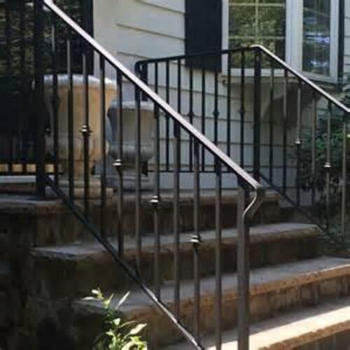

{'SpatialVQA': '1'}


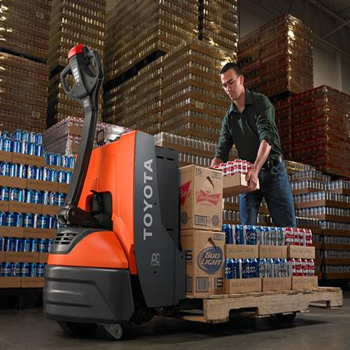

{'SpatialVQA': '3'}


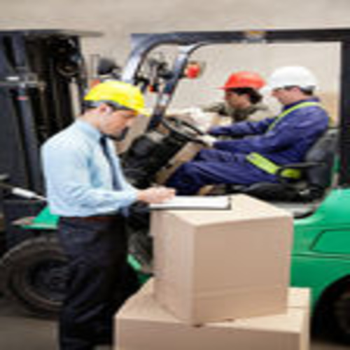

In [ ]:
for idx in range(3):
  print(run_example("SpatialVQA", 'How many people are in this scene.', data['train'][idx]['images'][0]))
  display(data['train'][idx]['images'][0].resize([350, 350]))